# Model training

In this file, I want to build and train some models and select the best predictor of ace/no ace.

## Importing libraries

In [1]:
# Import everything from my_libraries.py
from my_libraries import *  # noqa: F403

# Other utilities
import tennis_utils
import dataframe_utils

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

2025-02-10 00:43:44.660582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read into dataframe
df = pd.read_csv("datasets/task_set.csv")

# Clean dataframe
df = dataframe_utils.clean_dataframe(df)
# Impute missing values
df = dataframe_utils.impute_data(df)

In [3]:
# Split data while maintaining the proportion of 'is_ace'
X = df.drop("is_ace", axis=1)
y = df["is_ace"]

# Perform stratified split using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Save the train dataset in a new csv file
train_df = X_train
test_df = X_test
train_df["is_ace"] = y_train
train_df.to_csv("datasets/train_dataset.csv")

In [4]:
X

,surface,serve_side,serve_number,ball_hit_y,ball_hit_x,ball_hit_z,ball_hit_v,ball_net_v,ball_net_z,ball_net_y,ball_bounce_x,ball_bounce_y,ball_bounce_v,ball_bounce_angle,hitter_x,hitter_y,receiver_x,receiver_y,hitter_hand,receiver_hand
0,hard,deuce,2,-1.459,-11.445,2.830,91.5,67.9,1.241,0.980,4.392,2.278,60.7,19.216,-11.739,-1.398,13.343,3.570,right,left
1,hard,ad,1,1.083,-11.228,2.817,125.5,97.7,1.019,-0.026,4.528,-0.618,88.8,12.428,-11.744,1.131,15.459,-4.067,left,right
2,hard,deuce,1,-0.835,-11.149,2.793,109.7,85.5,1.156,2.082,5.378,3.744,75.3,12.737,-11.538,-0.647,13.679,3.544,right,right
3,clay,ad,2,1.424,-11.488,2.727,97.1,74.1,1.095,-1.170,3.915,-1.853,68.1,17.743,-11.690,1.169,11.378,-3.402,right,right
4,hard,ad,1,0.472,-10.985,2.660,121.0,95.7,1.094,-0.301,5.267,-0.525,85.5,12.013,-11.508,0.559,14.323,-3.629,right,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187921,hard,deuce,2,-0.303,-11.230,2.725,92.6,73.2,1.230,1.833,4.921,3.108,65.6,15.935,-11.573,-0.361,15.278,3.645,right,right
187922,hard,ad,1,0.886,-11.358,2.813,112.3,86.1,1.083,-2.094,4.636,-3.113,76.6,13.120,-11.615,0.844,13.219,-3.299,right,right
187923,hard,ad,1,1.395,-11.254,2.782,104.0,78.7,1.140,-2.276,4.499,-3.556,70.5,16.639,-11.625,1.050,14.470,-3.828,right,right
187924,clay,deuce,1,-0.623,-11.179,2.806,130.4,104.1,1.203,0.735,6.308,1.568,92.2,10.420,-11.616,-0.988,14.068,3.368,right,right


In [5]:
X_train.drop(columns="is_ace", inplace=True)

In [6]:
X_train = dataframe_utils.feature_engineer(X_train)
X_test = dataframe_utils.feature_engineer(X_test)

## Imbalanced dataset

Almost 92% of serves are not aces. The data is highly imbalanced. For the machine learning model to learn effectively, the data has to be balanced. I am using the random oversampler for this. Note that there are not too many unique ways you can serve an ace. ie: high serve speed, aim at the lines, hit where your opponent doesn't expect you to but this will still be to the leftmost or rightmost of the ad/deuce court.

In [7]:
y_train.value_counts()

is_ace
0    114397
1      9923
Name: count, dtype: int64

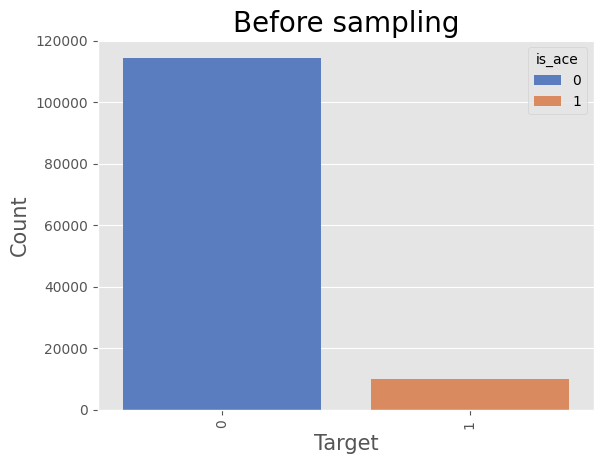

In [8]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("Before sampling", fontsize=20)
plt.show()

In [57]:
# # Random oversampling to make the majority and minority class even

# rd_over_sample = RandomOverSampler()
# X_train, y_train = rd_over_sample.fit_resample(X_train, y_train)

In [9]:
# SMOTE sampling
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

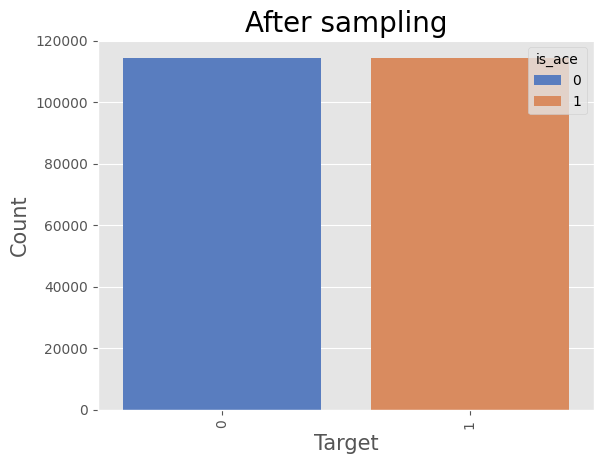

In [10]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("After sampling", fontsize=20)
plt.show()

# Models

In [11]:
def scoring():
    """A function to print scores and save them in lists."""

    print("-----Test Data Accuracy----")
    a_s = round(accuracy_score(y_test.to_numpy(), y_pred), 4)
    print("Accuracy score:", a_s)
    f_1 = round(f1_score(y_test.to_numpy(), y_pred), 4)
    print("F1 score:", f_1)
    accuracy_test.append(a_s)
    F1score_test.append(f_1)

    print("\n-----Train Data Accuracy----")
    a_s = round(accuracy_score(y_train.to_numpy(), y_pred_train), 4)
    print("Accuracy score:", a_s)
    f_1 = round(f1_score(y_train.to_numpy(), y_pred_train), 4)
    print("F1 score:", f_1)
    accuracy_train.append(a_s)
    F1score_train.append(f_1)

In [12]:
# Saving model scores in list for final evaluation
accuracy_test = []
accuracy_train = []
F1score_test = []
F1score_train = []

## Random Forest Classifer

In [13]:
# Got the best split from the GridSearchCV below
rfc = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=50, min_samples_split=6)

# Training Model
rfc.fit(X_train, y_train)
# Save model
joblib.dump(rfc, "rfc_model.joblib")
# Load model
saved_model = joblib.load("rfc_model.joblib")
# Predict
y_pred = saved_model.predict(X_test)
y_pred_train = saved_model.predict(X_train)

In [14]:
scoring()

-----Test Data Accuracy----
Accuracy score: 0.8822
F1 score: 0.5337

-----Train Data Accuracy----
Accuracy score: 0.9076
F1 score: 0.9092


### Using gridsearch cv for hyper parameter tuning

In [63]:
# param_grid = [
#     {
#         "n_estimators": [20, 50],
#         "max_depth": [5, 7, 10],
#         "min_samples_split": [2, 3, 6],
#     }
# ]

# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(),
#     param_grid=param_grid,
#     cv=2,
#     return_train_score=True,
#     verbose=True,
# )
# grid_search.fit(X_train, y_train)

# # Save the model so you don't have to run Gridsearchcv again.
# # Access the best model
# best_model = grid_search.best_estimator_
# best_parameters = grid_search.best_params_
# best_score = grid_search.best_score_

# # Save the best model to a file using joblib
# joblib.dump(best_model, "best_random_forest_model.joblib")

# # Grid_search.cv_results_ is a dictonary of each iteration of grid search, saving parameters and test and train scores.
# # Converting that to a df and saving as a csv so it can be accessed whenever.

# cv_results_df = pd.DataFrame(grid_search.cv_results_)
# cv_results_df.to_csv("cv_results.csv")

Obtaining the top ten most important features.

In [15]:
# Extract feature importances
importances = saved_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort features by importance
top_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Display the top 10 features
print("Top 10 Features for Serve Prediction:")
print(top_features)

Top 10 Features for Serve Prediction:
                          Feature  Importance
12  dist_ball_bounce_y_returner_y    0.163934
20           close_to_center_line    0.148853
1                   ball_bounce_y    0.141856
5                      ball_hit_v    0.139011
19             close_to_side_line    0.122052
18                   serve_number    0.091459
8               ball_bounce_angle    0.066238
10                     receiver_x    0.022681
6                      ball_net_z    0.017871
7                   ball_bounce_x    0.013205


Three of new features engineered have made it into the top 10, two making it to top 2.

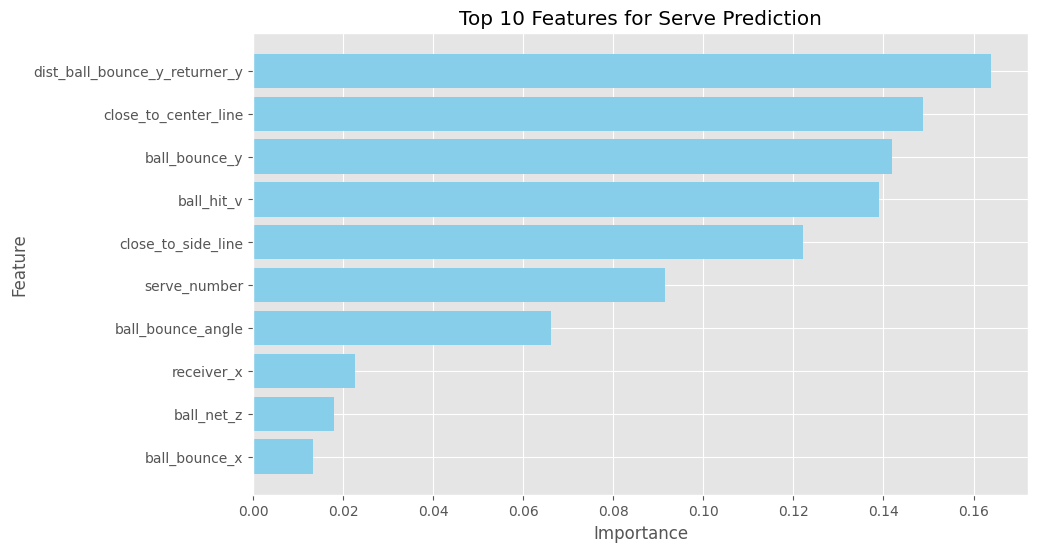

In [16]:
# Visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features for Serve Prediction')
plt.gca().invert_yaxis()
plt.show()

In [17]:
# Sort features by importance
worst_features = feature_importance_df.sort_values(by='Importance', ascending=True).head(10)

# Display the top 10 features
print("Worst 10 Features for Serve Prediction:")
print(worst_features)

Worst 10 Features for Serve Prediction:
                  Feature  Importance
17     receiver_hand_left    0.001214
21  close_to_service_line    0.001645
9                hitter_x    0.002323
16       hitter_hand_left    0.002735
14           surface_hard    0.004418
15       serve_side_deuce    0.004538
13           surface_clay    0.006276
4              ball_hit_z    0.007952
0              ball_hit_y    0.008768
3              ball_hit_x    0.009797


Dropping more columns

In [67]:
# new_columns_to_drop = ['receiver_hand_left', 'surface_hard', 'close_to_service_line','hitter_hand_left','serve_side_deuce','hitter_x']
# X_train.drop(columns=new_columns_to_drop, inplace=True)
# X_test.drop(columns=new_columns_to_drop, inplace=True)

### XG Boost

In [19]:
xgb = XGBClassifier(eval_metric="logloss", randome_state=42)

# Training Model
xgb.fit(X_train, y_train)

# Mode summary
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

scoring()

-----Test Data Accuracy----
Accuracy score: 0.9027
F1 score: 0.566

-----Train Data Accuracy----
Accuracy score: 0.9425
F1 score: 0.9436


In [22]:
joblib.dump(xgb, 'xgb_model.joblib')

['xgb_model.joblib']

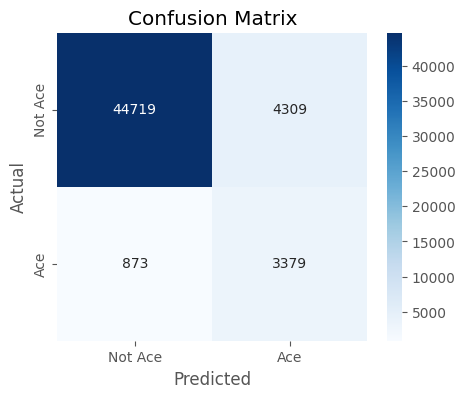

In [20]:
# Confusion Matrix Visualization
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Not Ace", "Ace"], yticklabels=["Not Ace", "Ace"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

More focus must be given to identifying why serves that are not aces are getting identified as aces.